# Setting up

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastai import *
from fastai.tabular import *

%matplotlib inline
sns.set(style = "whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [ ]:
# %%time
# path = 'D://Coding//XTX Forecasting Challenge//data-training.csv'
# df = pd.read_csv(path)

In [5]:
%%time
path = 'D://Coding//XTX Forecasting Challenge//data-training.file'
df = pd.read_feather(path, use_threads=8)
df = df.astype('float32')

Wall time: 7.18 s


In [6]:
df.columns

Index(['askRate0', 'askRate1', 'askRate2', 'askRate3', 'askRate4', 'askRate5',
       'askRate6', 'askRate7', 'askRate8', 'askRate9', 'askRate10',
       'askRate11', 'askRate12', 'askRate13', 'askRate14', 'askSize0',
       'askSize1', 'askSize2', 'askSize3', 'askSize4', 'askSize5', 'askSize6',
       'askSize7', 'askSize8', 'askSize9', 'askSize10', 'askSize11',
       'askSize12', 'askSize13', 'askSize14', 'bidRate0', 'bidRate1',
       'bidRate2', 'bidRate3', 'bidRate4', 'bidRate5', 'bidRate6', 'bidRate7',
       'bidRate8', 'bidRate9', 'bidRate10', 'bidRate11', 'bidRate12',
       'bidRate13', 'bidRate14', 'bidSize0', 'bidSize1', 'bidSize2',
       'bidSize3', 'bidSize4', 'bidSize5', 'bidSize6', 'bidSize7', 'bidSize8',
       'bidSize9', 'bidSize10', 'bidSize11', 'bidSize12', 'bidSize13',
       'bidSize14', 'y'],
      dtype='object')

# Exploratory Data Analysis

In [ ]:
# # Plot of [y] distribution
# fig, ax = plt.subplots(figsize=(15,8))
# sns.kdeplot(df.y, bw=0.01)

In [ ]:
# Some feature engineering
df.fillna(0, inplace=True)
df['spread'] = df.askRate0 - df.bidRate0
df['midRate'] = (df.askRate0 + df.bidRate0) / 2


In [117]:
# # Figuring out what [y] is
# # y(t) is midRate(t+87) - midRate(t), clipped to (-5.5)
# df['expectedY'] = df.midRate.diff(87).shift(-87).clip(-5,5)
# print(sum(df.y == df.expectedY))
# df.loc[df.y != df.expectedY]

# fig, ax = plt.subplots(figsize=(15,8))
# i = 500
# shift = 87
# # plt.plot(df.index[0:i], df.midRate[0:i].diff(shift).shift(-shift+14))
# plt.plot(df.index[-i:], df.midRate[-i:].diff(shift).shift(-shift))
# plt.plot(df.index[-i:], df.y[-i:])
# plt.legend(('midRate', 'y'))

# Feature engineering

### Basics

In [9]:
bidSizeList = ['bidSize' + str(i) for i in range(0,15)]
askSizeList = ['askSize' + str(i) for i in range(0,15)]
bidRateList = ['bidRate' + str(i) for i in range(0,15)]
askRateList = ['askRate' + str(i) for i in range(0,15)]

In [ ]:
df['totalBidVol1'] = df.bidSize0 + df.bidSize1
df['totalAskVol1'] = df.askSize0 + df.askSize1
for i in range(2,15):
    df['totalBidVol' + str(i)] = df['totalBidVol' + str(i-1)] + df['bidSize' + str(i)]
    df['totalAskVol' + str(i)] = df['totalAskVol' + str(i-1)] + df['askSize' + str(i)]

for i in range(1,15):
    df['bidAskRatio' + str(i)] = df['totalBidVol' + str(i)] / df['totalAskVol' + str(i)]

df['totalAvailVol'] = df.totalBidVol14 + df.totalAskVol14

In [ ]:
df['vwaBid'] = np.einsum('ij,ji->i', df[bidRateList], df[bidSizeList].T) / df[bidSizeList].sum(axis=1)
df['vwaAsk'] = np.einsum('ij,ji->i', df[askRateList], df[askSizeList].T) / df[askSizeList].sum(axis=1)
df['vwaBidDMid'] = df.midRate - df.vwaBid
df['vwaAskDMid'] = df.vwaAsk - df.midRate
df['diff_vwaBidAskDMid'] = df.vwaAskDMid - df.vwaBidDMid

# Ideas from papers

In [ ]:
# Volume Order Imbalance
b1, a1 = (df.bidRate0 < df.bidRate0.shift(-1)), (df.askRate0 < df.askRate0.shift(-1))
b2, a2 = (df.bidRate0 == df.bidRate0.shift(-1)), (df.askRate0 == df.askRate0.shift(-1))
valsB, valsA = [0, (df.bidSize0 - df.bidSize0.shift(-1))], [0, (df.askSize0 - df.askSize0.shift(-1))]
defaultB, defaultA = df.bidSize0, df.askSize0

df['deltaVBid'] = np.select([b1,b2], valsB, default=defaultB)
df['deltaVAsk'] = np.select([a1,a2], valsA, default=defaultA)
df['VOI'] = df.deltaVBid - df.deltaVAsk

# Order Imbalance Ratio: when OIR is small, suggests that signal from VOI is weak
df['OIR'] = (df.bidSize0 - df.askSize0)/(df.bidSize0 + df.askSize0)

In [ ]:
df.to_feather('intermediate.file')

In [ ]:
# drop original features
df.drop(df.columns[:60], axis=1, inplace=True)

In [16]:
df = pd.read_feather('intermediate.file')

# Fast.ai

In [3]:
dep_var = 'y'
procs = [FillMissing, Normalize]

In [4]:
path = f'D:\Coding\XTX Forecasting Challenge'
data = TabularDataBunch.from_df(path = path, df = df[:int(5e5)], dep_var = 'y', procs=procs,
                                 valid_idx = list(range(int(4e5),int(5e5))))

In [ ]:
data.show_batch(rows=10)

In [ ]:
# data = (TabularList.from_df(df[:int(5e5)], cont_names=df.columns, procs=procs)
#                            .split_by_idx(list(range(int(0.8*5e5),int(5e5))))
#                            .label_from_df(cols=dep_var, label_cls=FloatList)
#                            .databunch())

In [29]:
learn = tabular_learner(data, layers=[500,200], metrics=r2_score, ps=[0.001,0.01], emb_drop=0.04)

In [30]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(114, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=114, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=500, out_features=200, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [11]:
learn.lr_find(end_lr=1e1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


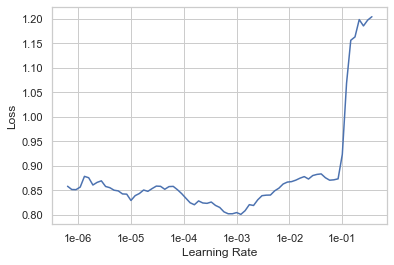

In [12]:
learn.recorder.plot()

In [ ]:
# model above has already diverged, we will restart.

In [31]:
learn.fit_one_cycle(3, 1e-4, wd=0.1)

epoch,train_loss,valid_loss,r2_score,time
0,0.568406,0.641813,-inf,04:21
1,0.488415,0.786832,-inf,04:18
2,0.479876,0.695911,-inf,04:06


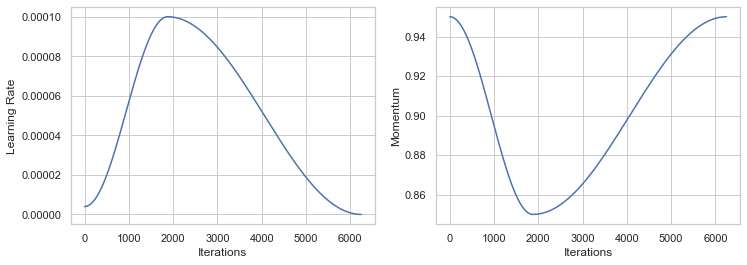

In [14]:
learn.recorder.plot_lr(show_moms=True)

In [32]:
learn.save('new_fastai')

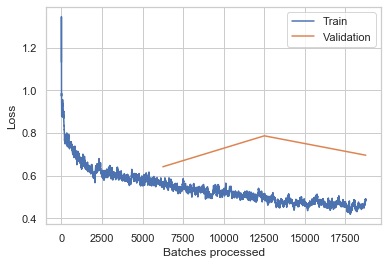

In [33]:
learn.recorder.plot_losses()

In [38]:
learn.predict(df.iloc[int(8.1e5)])

(FloatItem [0.449099], tensor([0.4491]), tensor([0.4491]))

In [39]:
df.y.iloc[int(8.1e5)]

0.25

In [40]:
preds = learn.get_preds()

# TA

In [ ]:
# Rolling ohlc
df_ask = df.askRate0.to_frame()
df_ask['openAsk'] = df_ask.askRate0.shift(15-1)
df_ask['highAsk'] = df_ask.askRate0.rolling(window=15).max().fillna(0)
df_ask['lowAsk'] = df_ask.askRate0.rolling(window=15).min().fillna(0)
df_ask = df_ask[['openAsk','highAsk','lowAsk','askRate0']].join(df.askSize0)

df_bid = df.bidRate0.to_frame()
df_bid['openBid'] = df_bid.bidRate0.shift(15-1)
df_bid['highBid'] = df_bid.bidRate0.rolling(window=15).max().fillna(0)
df_bid['lowBid'] = df_bid.bidRate0.rolling(window=15).min().fillna(0)
df_bid = df_bid[['openBid','highBid','lowBid','bidRate0']].join(df.bidSize0)

In [ ]:
import ta
df_ask_ta = ta.add_all_ta_features(df_ask, "openAsk", "highAsk", "lowAsk", "askRate0", "askSize0", fillna=True)


In [ ]:
df_bid_ta = ta.add_all_ta_features(df_ask, "openBid", "highBid", "lowBid", "askRate0", "bidRate0", fillna=True)

# Feature Selection

In [4]:
%%time
X = df.drop('y', axis=1).values
y = df.y.values

Wall time: 961 ms


In [55]:
# normalise
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# pca
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_scaled)

# Cross-validation

In [5]:
%%time
# for regression
X = df.drop('y', axis=1).values
y = df.y.values

Wall time: 918 ms


In [6]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from rolling import RollingWindowSplit

rlcv = RollingWindowSplit(n_splits=5, compatible=True)
for inc, (train_index, valid_index) in enumerate(rlcv.split(X), 1):
    x_train, x_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    print("TRAIN:", (train_index[0], train_index[-1]),
          "VALID:", (valid_index[0], valid_index[-1]),
          "SIZES:", (len(x_train), len(x_valid)))

TRAIN: (2, 428572) VALID: (428573, 857143) SIZES: (428571, 428571)
TRAIN: (428573, 857143) VALID: (857144, 1285714) SIZES: (428571, 428571)
TRAIN: (857144, 1285714) VALID: (1285715, 1714285) SIZES: (428571, 428571)
TRAIN: (1285715, 1714285) VALID: (1714286, 2142856) SIZES: (428571, 428571)
TRAIN: (1714286, 2142856) VALID: (2142857, 2571427) SIZES: (428571, 428571)


In [108]:
lasso = LassoLarsCV(cv=rlcv, n_jobs=-1).fit(X, y)

TRAIN: (2, 428572) VALID: (428573, 857143) SIZES: (428571, 428571)
TRAIN: (428573, 857143) VALID: (857144, 1285714) SIZES: (428571, 428571)
TRAIN: (857144, 1285714) VALID: (1285715, 1714285) SIZES: (428571, 428571)
TRAIN: (1285715, 1714285) VALID: (1714286, 2142856) SIZES: (428571, 428571)
TRAIN: (1714286, 2142856) VALID: (2142857, 2571427) SIZES: (428571, 428571)


In [57]:
print(pca.explained_variance_ratio_)

[0.339363 0.148498 0.112511 0.038578 0.030945 0.02155  0.02029  0.019281 0.018302 0.0176   0.015209 0.014452 0.01338
 0.011426 0.009937 0.00914  0.00901  0.008673 0.008383 0.008    0.007726 0.007239 0.007173 0.00712  0.006848 0.006796
 0.006497 0.006261 0.006212 0.006134]


# Lasso

In [ ]:
# LASSO regression
from sklearn.linear_model import LassoLarsCV
lasso = LassoLarsCV(cv=rlcv, n_jobs=-1).fit(X, y)
print(f'{lasso.score(x_train, y_train):.3f}, {lasso.score(x_valid, y_valid):.3f}')

In [108]:
lasso = LassoLarsCV(cv=rlcv, n_jobs=-1).fit(X, y)
dump(lasso, f'lasso_rlcv_114ft_0.0175_0.0187.joblib')

TRAIN: (2, 428572) VALID: (428573, 857143) SIZES: (428571, 428571)
TRAIN: (428573, 857143) VALID: (857144, 1285714) SIZES: (428571, 428571)
TRAIN: (857144, 1285714) VALID: (1285715, 1714285) SIZES: (428571, 428571)
TRAIN: (1285715, 1714285) VALID: (1714286, 2142856) SIZES: (428571, 428571)
TRAIN: (1714286, 2142856) VALID: (2142857, 2571427) SIZES: (428571, 428571)


In [108]:
print(f'{lasso.score(x_train, y_train):.4f}, {lasso.score(x_valid, y_valid):.4f}')

TRAIN: (2, 428572) VALID: (428573, 857143) SIZES: (428571, 428571)
TRAIN: (428573, 857143) VALID: (857144, 1285714) SIZES: (428571, 428571)
TRAIN: (857144, 1285714) VALID: (1285715, 1714285) SIZES: (428571, 428571)
TRAIN: (1285715, 1714285) VALID: (1714286, 2142856) SIZES: (428571, 428571)
TRAIN: (1714286, 2142856) VALID: (2142857, 2571427) SIZES: (428571, 428571)


In [7]:
# dump(lasso, 'lasso_rlcv_114ft_0.0175_0.0187.joblib')

In [104]:
lasso = load('lasso_rlcv_114ft_0.0175_0.0187.joblib') 

In [110]:
sigmoid = (1/(1+np.exp(-0.22*lasso.predict(x_valid)))-0.5)*20

In [111]:
r2d2(y_valid, sigmoid)

0.01894224448898718

In [15]:
from sklearn.metrics import r2_score as r2d2

In [103]:
r2d2(y_valid, lasso.predict(x_valid))

0.02102596287515801

In [81]:
lasso.predict(np.atleast_2d(df.iloc[0].drop('y').to_list()))

array([0.138818])

# RF

In [134]:
def rlcvscore(model):
    cvtrain, cvvalid = [], []
    for inc, (train_index, valid_index) in enumerate(rlcv.split(X), 1):
        x_train, x_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        cvtrain.append(model.score(x_train, y_train))
        cvvalid.append(model.score(x_valid, y_valid))
    print(f'{np.array(cvtrain).round(4)}')
    print(f'{np.array(cvvalid).round(4)}')
    print(f'{np.mean(cvtrain):.4f}, {np.mean(cvvalid):.4f}')

In [139]:
rf_model = RandomForestRegressor(n_estimators=10, max_depth=6, min_samples_split=1000, min_samples_leaf=1000,
                                 max_features='auto', n_jobs=-1, random_state=41)

In [15]:
for i in range(1,15):
    df['dAskRate' + str(i)] = df.askRate0.diff(i)

NameError: name 'df' is not defined

In [7]:
df[['askRate0', 'dAskRate0']].tail(100)

,askRate0,dAskRate0
2999899,1584.5,0.0
2999900,1584.5,0.0
2999901,1584.5,0.0
2999902,1584.5,0.0
2999903,1584.5,0.0
2999904,1584.5,0.0
2999905,1584.5,0.0
2999906,1584.5,0.0
2999907,1584.5,0.0
2999908,1584.5,0.0


In [284]:
(df.askRate0.diff(87)).corr(df.y)

-0.014467340775302278

In [292]:
(df.askRate0.diff(87)[:100000]).corr(df.y[:100000])

-0.016979444501644472

In [285]:
(df.midRate.diff(87)).corr(df.y)

-0.014179611964623053

In [191]:
rf_model.fit(x_train, y_train);

In [141]:
rlcvscore(rf_model) # realistic cv

[ 0.0561  0.0039 -0.0016  0.0003  0.0088]
[ 0.0039 -0.0016  0.0003  0.0088  0.0044]
0.0135, 0.0032


In [152]:
a = df.drop('y', axis=1).columns[indices]

In [157]:
a[:30] # these are the important variables

Index(['spread', 'OIR', 'bidAskRatio1', 'totalAskVol12', 'bidAskRatio12',
       'totalAskVol11', 'bidAskRatio2', 'bidAskRatio13', 'deltaVBid', 'vwaBid',
       'diff_vwaBidAskDMid', 'bidAskRatio3', 'totalAskVol9', 'totalBidVol13',
       'totalAskVol1', 'bidAskRatio7', 'totalBidVol12', 'bidSize2',
       'bidAskRatio14', 'totalBidVol9', 'bidAskRatio5', 'totalBidVol11', 'VOI',
       'totalBidVol6', 'bidAskRatio6', 'bidAskRatio11', 'askSize12',
       'bidSize13', 'totalBidVol5', 'bidSize8'],
      dtype='object')

In [195]:
# create X with important variables only
X = df.drop('y', axis=1)[a[:20]].values
y = df.y.values

In [196]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from rolling import RollingWindowSplit
from joblib import dump, load

rlcv = RollingWindowSplit(n_splits=5, compatible=True)
for inc, (train_index, valid_index) in enumerate(rlcv.split(X), 1):
    x_train, x_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    print("TRAIN:", (train_index[0], train_index[-1]),
          "VALID:", (valid_index[0], valid_index[-1]),
          "SIZES:", (len(x_train), len(x_valid)))
    if inc: break

TRAIN: (2, 428572) VALID: (428573, 857143) SIZES: (428571, 428571)


In [224]:
rf_model = RandomForestRegressor(n_estimators=10, max_depth=2, min_samples_split=2, min_samples_leaf=5000,
                                 max_features='auto', n_jobs=-1, random_state=41)

In [225]:
rf_model.fit(x_train, y_train);

In [226]:
rlcvscore(rf_model)

[0.014  0.0081 0.0072 0.0047 0.0098]
[0.0081 0.0072 0.0047 0.0098 0.0068]
0.0088, 0.0073


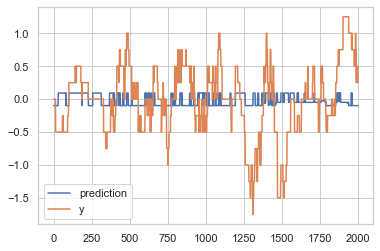

In [233]:
plt.plot(rf_model.predict(x_valid)[:2000])
plt.plot(y_valid[:2000])
plt.legend(('prediction', 'y'))

In [167]:
rlcvscore(rf_model) #n_est 10, depth 6, 1000, 1000, 30 most importantvariables

[ 0.0554  0.0033 -0.0017  0.0015  0.0089]
[ 0.0033 -0.0017  0.0015  0.0089  0.0047]
0.0135, 0.0033


Feature ranking:
1. feature 60 (0.187222)
2. feature 113 (0.137414)
3. feature 90 (0.062060)
4. feature 87 (0.061551)
5. feature 101 (0.057842)
6. feature 86 (0.044337)
7. feature 91 (0.040228)
8. feature 102 (0.031975)
9. feature 110 (0.025626)
10. feature 105 (0.025411)
11. feature 109 (0.021539)
12. feature 92 (0.021490)
13. feature 84 (0.020808)
14. feature 74 (0.016204)
15. feature 76 (0.015854)
16. feature 96 (0.015558)
17. feature 73 (0.015418)
18. feature 47 (0.015032)
19. feature 103 (0.014706)
20. feature 70 (0.014339)
21. feature 94 (0.012646)
22. feature 72 (0.012472)
23. feature 112 (0.010613)
24. feature 67 (0.008538)
25. feature 95 (0.008353)
26. feature 100 (0.007845)
27. feature 27 (0.007749)
28. feature 58 (0.007206)
29. feature 66 (0.005776)
30. feature 53 (0.005330)
31. feature 65 (0.004836)
32. feature 106 (0.004814)
33. feature 75 (0.004757)
34. feature 104 (0.004420)
35. feature 52 (0.003651)
36. feature 89 (0.003611)
37. feature 97 (0.002936)
38. feature 19 (0.0

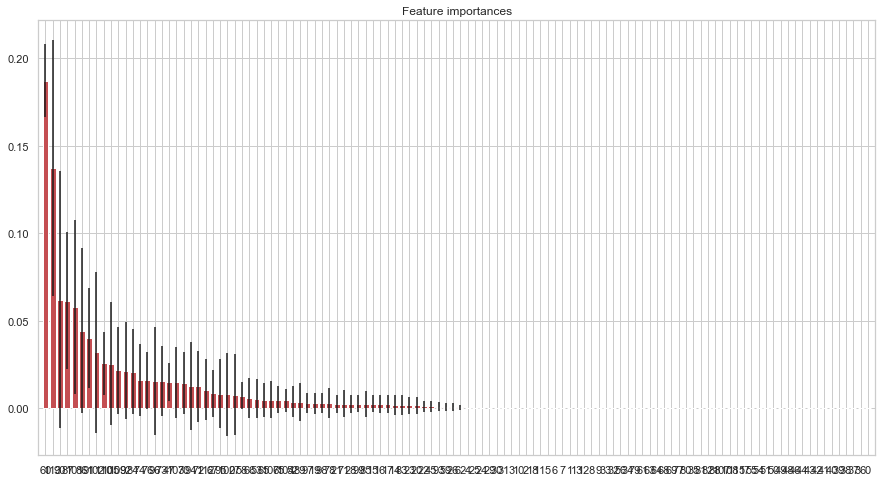

In [143]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
# save model
from joblib import dump, load
dump(rf, 'model.joblib')

In [ ]:
# load model
rf2 = load('model.joblib')